In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf
import tensorflow_model_optimization as tfmot

2026-01-23 02:24:07.724214: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-23 02:24:07.749613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2026-01-23 02:24:11.024659: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


ImportError: Keras cannot be imported. Check that it is installed.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
#from tf.keras import layers,models

import tf_keras as keras

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 48
ALPHA = 0.35

dir = os.listdir();path = dir[dir.index("data")]

d_train = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='train',
    seed=42,
    label_mode='categorical',
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
)

d_val = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='valid',
    seed=42,
    label_mode='categorical',
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = d_train.class_names

print(f"\nClasses:\n{class_names}")

d_train = d_train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
d_val = d_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1633 files belonging to 2 classes.
Using 1307 files for training.
Found 1633 files belonging to 2 classes.
Using 326 files for validation.

Classes:
['fire', 'non_fire']


In [73]:
def recall_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    
    recall = true_positives / (possible_positives + 1e-7)
    return recall

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + 1e-7)
    return precision

def f1_m(y_true, y_pred):
    p = precision_m(y_true, y_pred)
    r = recall_m(y_true, y_pred)
    return 2 * ((p * r) / (p + r + 1e-7))

## Not simulating Esp CAM conditions

In [74]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    alpha = ALPHA,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./127.5,offset=-1,input_shape=(IMG_SIZE,IMG_SIZE,3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names),activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(class_id=0, name='precision'),
        tf.keras.metrics.Recall(class_id=0, name='recall'),
        f1_m
    ]
)

model.summary()

history = model.fit(
    d_train,
    validation_data=d_val,
    epochs=7
)

print(f"train_acc: {history.history['accuracy']}\nval_acc: {history.history['val_accuracy']}")



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 mobilenetv2_0.35_224 (Func  (None, 2, 2, 1280)        410208    
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 412770 (1.57 MB)
Trainable params: 2562 

In [75]:
def history_plotter(history):
    fig, axs = plt.subplots(2,3,figsize=(12,8),dpi=100)

    # Acc
    axs[0, 0].plot(history.history['accuracy'], label='Training Acc')
    axs[0, 0].plot(history.history.get('val_accuracy', []), label='Validation Acc')
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].legend()

    # Loss
    axs[0, 1].plot(history.history['loss'], label='Training Loss')
    axs[0, 1].plot(history.history.get('val_loss', []), label='Validation Loss')
    axs[0, 1].set_title('Loss')
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].legend()

    # F1 Score 
    axs[0, 2].plot(history.history['f1_m'], label='Training F1')
    axs[0, 2].plot(history.history.get('val_f1_m', []), label='Validation F1')
    axs[0, 2].set_title('F1 Score')
    axs[0, 2].set_ylabel("F1")
    axs[0, 2].set_xlabel("Epochs")
    axs[0, 2].legend()


    # Precision 
    axs[1, 0].plot(history.history['precision'], label='Training Precision')
    axs[1, 0].plot(history.history.get('val_precision', []), label='Validation Precision')
    axs[1, 0].set_title('Precision')
    axs[1, 0].set_ylabel("Precision")
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].legend()

    # Recall 
    axs[1, 1].plot(history.history['recall'], label='Training Recall')
    axs[1, 1].plot(history.history.get('val_recall', []), label='Validation Recall')
    axs[1, 1].set_title('Recall')
    axs[1, 1].set_ylabel("Recall")
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].legend()

    fig.delaxes(axs[1, 2])

    plt.tight_layout()
    plt.legend()
    plt.show()

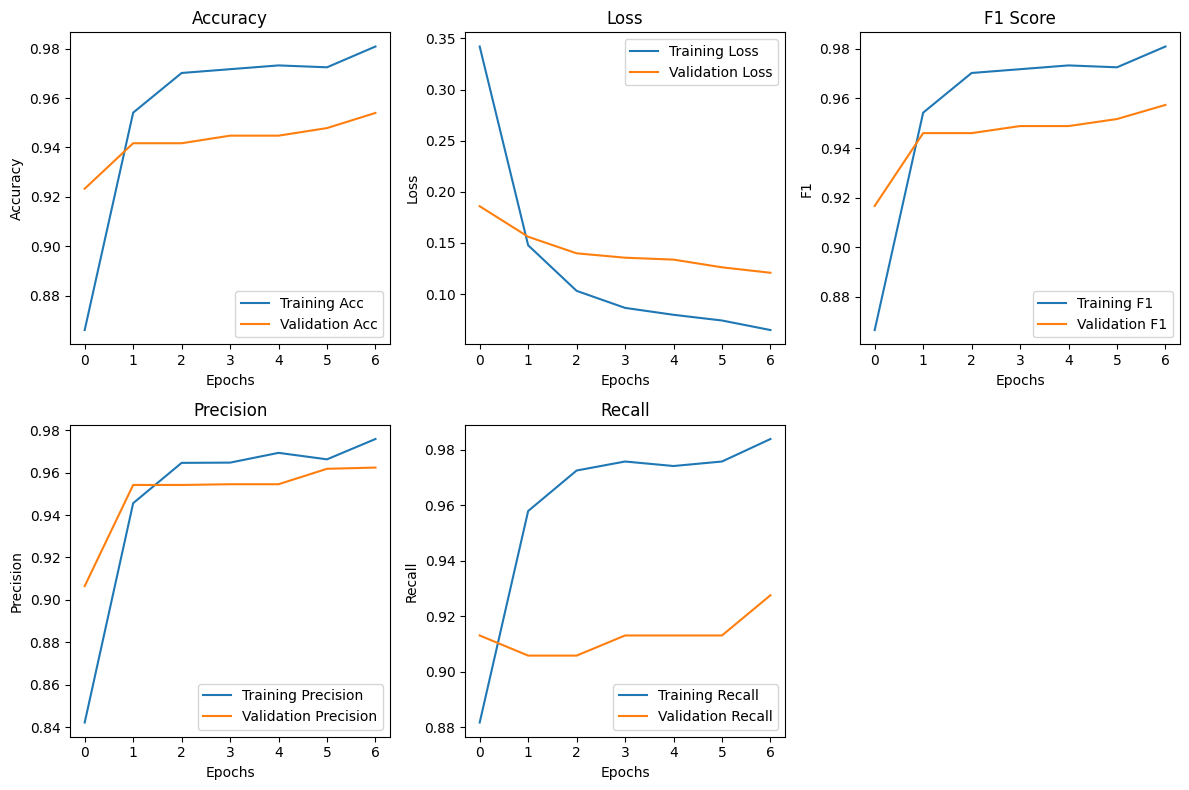

In [76]:
history_plotter(history)

In [77]:
acc, f1, loss, precision, recall = model.evaluate(d_val)

print(acc, f1, loss, precision, recall)

 1/11 [=>............................] - ETA: 0s - loss: 0.1446 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.8333 - f1_m: 0.9375

11/11 [==============================] - 0s 13ms/step - loss: 0.1209 - accuracy: 0.9540 - precision: 0.9624 - recall: 0.9275 - f1_m: 0.9574
0.12087763100862503 0.953987717628479 0.9624060392379761 0.9275362491607666 0.9573863744735718


In [78]:
import numpy as np

img_path = "non_fire_test.jpg"

img = tf.keras.utils.load_img(
    img_path, target_size=(48,48)
)

img_array = tf.keras.utils.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)


score = predictions[0] 
chosen_class = np.argmax(score)
class_name = class_names[chosen_class]

print(f"Resultado: {class_name}")
print(f"Confiança: {100 * np.max(score):.2f}%")

1/1 [==============================] - 0s 454ms/step
Resultado: fire
Confiança: 64.05%


## Simulating ESP conditions

In [79]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

augmented_train_data = d_train.map(lambda x,y: (data_augmentation(x,training=True),y),num_parallel_calls=tf.data.AUTOTUNE)


augmented_train_data = augmented_train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 mobilenetv2_0.35_224 (Func  (None, 2, 2, 1280)        410208    
 tional)                                                         
                                                                 
 global_average_pooling2d_6  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 412770 (1.57 MB)
Trainable params: 2562 

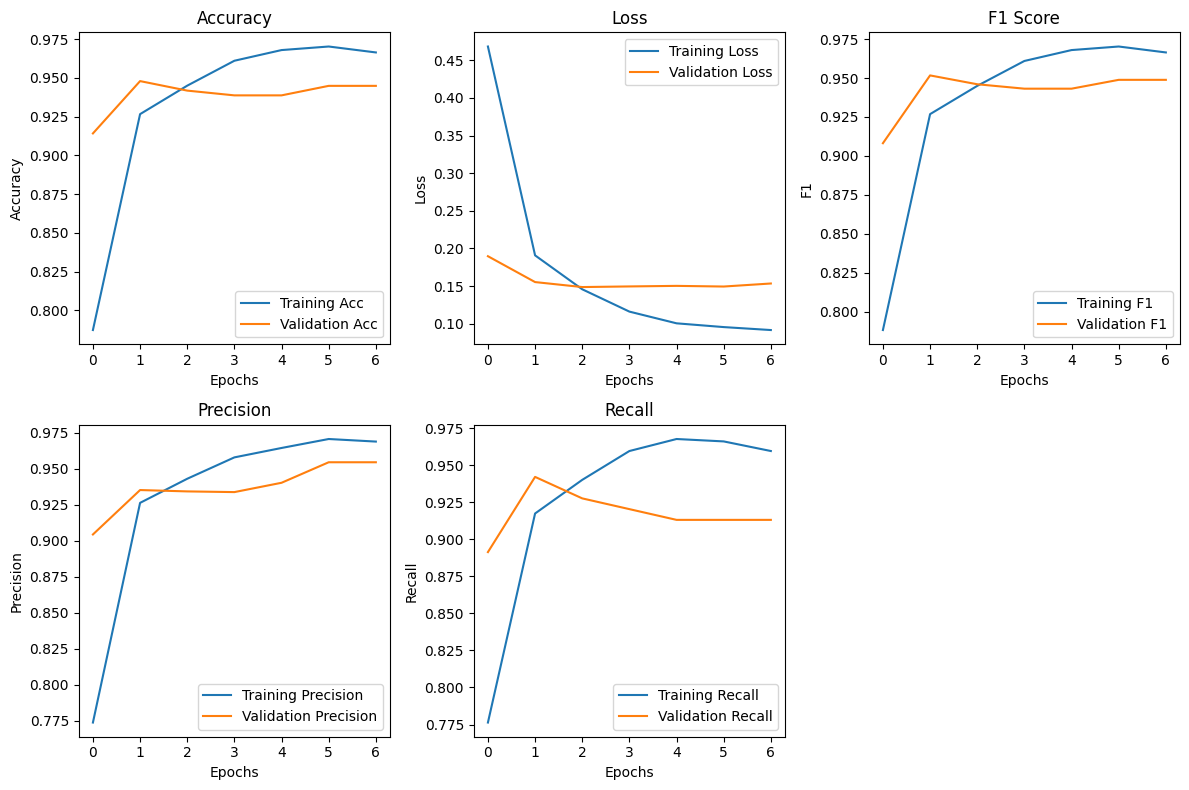

In [80]:
model_esp_conditions = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./127.5,offset=-1,input_shape=(IMG_SIZE,IMG_SIZE,3)),
    #layers.GaussianNoise(0.2),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names),activation='softmax')
])

model_esp_conditions.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(class_id=0, name='precision'),
        tf.keras.metrics.Recall(class_id=0, name='recall'),
        f1_m
    ]
)

model_esp_conditions.summary()

history_esp = model_esp_conditions.fit(
    augmented_train_data,
    validation_data=d_val,
    epochs=7
)

history_plotter(history_esp)


In [81]:
acc, f1, loss, precision, recall = model_esp_conditions.evaluate(d_val)

print(acc, f1, loss, precision, recall)


11/11 [==============================] - 0s 13ms/step - loss: 0.1534 - accuracy: 0.9448 - precision: 0.9545 - recall: 0.9130 - f1_m: 0.9489
0.15337461233139038 0.9447852969169617 0.9545454382896423 0.9130434989929199 0.9488636255264282


## Quantization and Pruning

### Prune


In [82]:
import tensorflow_model_optimization as tfmot
#from tensorflow_model_optimization.python.core.keras.compat import keras

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

epochs = 2

num_batch = len(d_train)
end_step = num_batch * epochs

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,
                                                             final_sparsity=0.8,
                                                             begin_step=0,
                                                             end_step=end_step)
                                                             
}

def apply_pruning_to_layer(layer):
    #ignora a camada de rescaling
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)

    return layer

# Usamos clone_model para reconstruir o modelo aplicando a função acima
model_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_layer,
)

model_pruning.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy',
                    tf.keras.metrics.Precision(class_id=0, name='precision'),
                    tf.keras.metrics.Recall(class_id=0, name='recall'),
                    f1_m])

print(model_pruning.summary())

model_pruning_esp = tf.keras.models.clone_model(
    model_esp_conditions,
    clone_function=apply_pruning_to_layer,
)

model_pruning_esp.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy',
                    tf.keras.metrics.Precision(class_id=0, name='precision'),
                    tf.keras.metrics.Recall(class_id=0, name='recall'),
                    f1_m])


print(model_pruning_esp.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 mobilenetv2_0.35_224 (Func  (None, 2, 2, 1280)        410208    
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 prune_low_magnitude_dense_  (None, 2)                 5124      
 5 (PruneLowMagnitude)                                           
                                                      

In [84]:
import tempfile

In [85]:
logdir = os.path.join("logs","prunning_fit_model")

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

history_prune_model = model_pruning.fit(d_train,
                  epochs=epochs,
                  validation_data=d_val,
                  callbacks=callbacks)

Epoch 1/2
41/41 [==============================] - 3s 32ms/step - loss: 0.0584 - accuracy: 0.9839 - precision: 0.9791 - recall: 0.9870 - f1_m: 0.9840 - val_loss: 0.1221 - val_accuracy: 0.9540 - val_precision: 0.9695 - val_recall: 0.9203 - val_f1_m: 0.9574
Epoch 2/2
41/41 [==============================] - 1s 18ms/step - loss: 0.0552 - accuracy: 0.9855 - precision: 0.9823 - recall: 0.9870 - f1_m: 0.9855 - val_loss: 0.1058 - val_accuracy: 0.9571 - val_precision: 0.9559 - val_recall: 0.9420 - val_f1_m: 0.9602


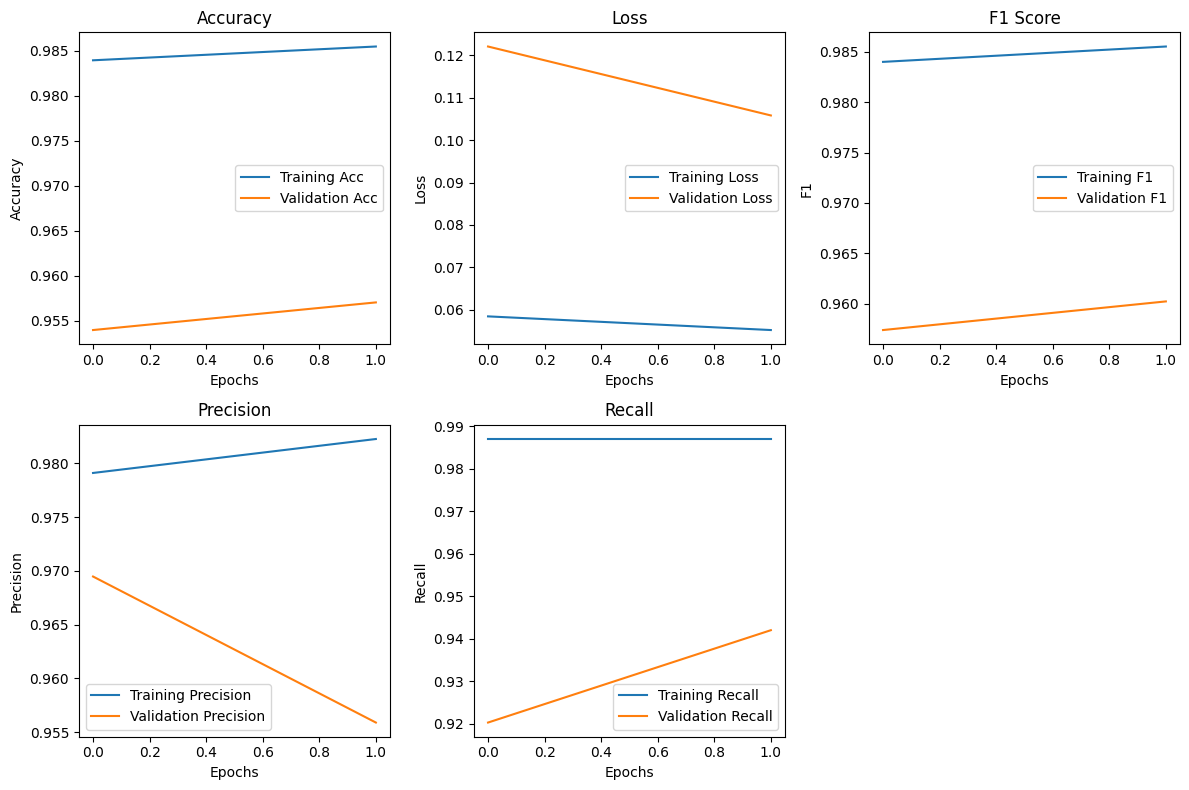

In [86]:
history_plotter(history_prune_model)

In [87]:
logdir = os.path.join("logs","prunning_fit_esp")

history_prune_esp = model_pruning_esp.fit(d_train,
                    epochs=epochs,
                  validation_data=d_val,
                  callbacks=callbacks)

Epoch 1/2
41/41 [==============================] - 3s 34ms/step - loss: 0.1091 - accuracy: 0.9640 - precision: 0.9612 - recall: 0.9627 - f1_m: 0.9642 - val_loss: 0.1401 - val_accuracy: 0.9509 - val_precision: 0.9621 - val_recall: 0.9203 - val_f1_m: 0.9545
Epoch 2/2
41/41 [==============================] - 1s 17ms/step - loss: 0.0840 - accuracy: 0.9732 - precision: 0.9678 - recall: 0.9757 - f1_m: 0.9733 - val_loss: 0.1374 - val_accuracy: 0.9540 - val_precision: 0.9695 - val_recall: 0.9203 - val_f1_m: 0.9574


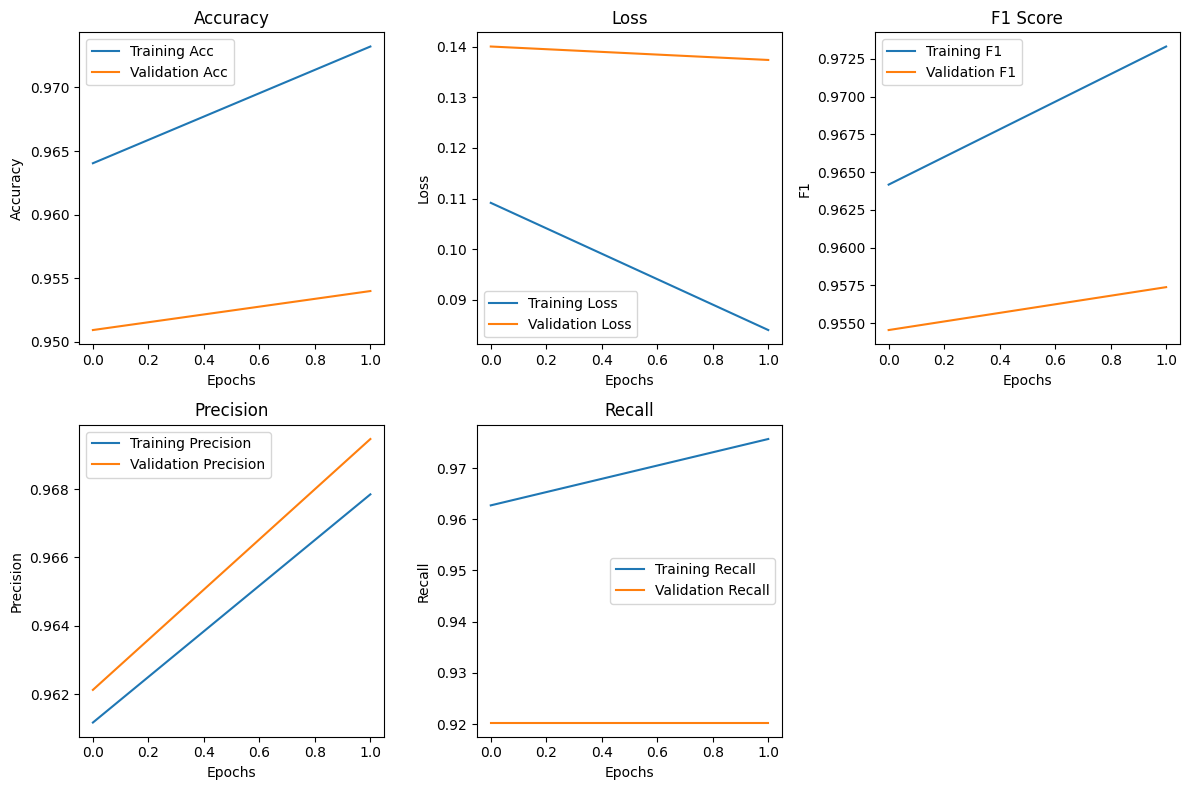

In [88]:
history_plotter(history_prune_esp)

In [89]:
model_export = tfmot.sparsity.keras.strip_pruning(model_pruning)

keras.models.save_model(model_export,"model",include_optimizer=False)

model_export_esp = tfmot.sparsity.keras.strip_pruning(model_pruning_esp)

keras.models.save_model(model_export_esp,"esp_model",include_optimizer=False)

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: esp_model\assets


INFO:tensorflow:Assets written to: esp_model\assets


In [90]:
converter_model = tf.lite.TFLiteConverter.from_keras_model(model_export)
converter_model.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_model_converted = converter_model.convert()

with open("fire_model_q.tflite", "wb") as f:
    f.write(pruned_model_converted)

INFO:tensorflow:Assets written to: C:\Users\vivil\AppData\Local\Temp\tmpc41w2nu4\assets


INFO:tensorflow:Assets written to: C:\Users\vivil\AppData\Local\Temp\tmpc41w2nu4\assets


In [91]:
converter_esp = tf.lite.TFLiteConverter.from_keras_model(model_export_esp)
converter_esp.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_esp_converted = converter_esp.convert()




with open("fire_model_esp_q.tflite", "wb") as f:
    f.write(pruned_esp_converted)

INFO:tensorflow:Assets written to: C:\Users\vivil\AppData\Local\Temp\tmp1n92n108\assets


INFO:tensorflow:Assets written to: C:\Users\vivil\AppData\Local\Temp\tmp1n92n108\assets
